### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

### Kernel
Doing PCA in the transformed dataset will need a lot of computations. But with the help of kernel methods, we can perform these computations in the original state space. So defining 3 kernels for our use: Linear, rbf and exponential

In [2]:
class kernel:
    def __init__(self, gamma = 1, sigma = 1, c = 0):
        self.gamma = gamma
        self.sigma = sigma
        self.c = c
        
    def linear(self, x, y):
        return np.matmul(x.T, y) + self.c
    
    def rbf(self, x, y):
        return np.exp(- self.gamma * (np.linalg.norm(x-y)**2))
    
    def exp(self, x, y):
        return np.exp(- (1/ (2*self.sigma**2)) * np.linalg.norm(x-y))    


### Implementation
<li>First we created a Kernel PCA class named "KPCA" and initialzed our data(X), Kernel(kernel) and dimensions(d).</li><br/>
<li>Then, we'll choose a kernel function k(x i, x j) and T will be any higher-dimensional transformation.</li><br/>
<li>We'll look for our data's covariance matrix. However, we will calculate this matrix using the kernel function. As a result, the kernel matrix, which is the matrix obtained by applying the kernel function to all pairs of data, will be computed. Center our kerenl matrix (this equivalent to substract the mean of the transformed data and dividing by standard deviations) :<br/>
<center><b><i>K_new = K - (I)K - K(I) + (I)K(I)</i></b></center>
<br/>
where I is a matrix that its all elements are equal to i/d. All this will be done in the function <b>"kernel_matrix"</b>.</li><br/>
<li>The eigenvectors and eigenvalues of this matrix will then be determined. Then sort our eigenvectors in decreasing order based on their corresponding eigenvalues. This will be done in the function <b>"decomposition".</b></li><br/>
<li>Let's call our reduced dataset m and choose the number of dimensions we want it to have. Then we'll concatenate our first m eigenvectors into a single matrix. Finally, multiply your data by the product of that matrix. Your new, smaller dataset will be the result. This will be done in the function <b>"project"</b>.</li><br/>

In [3]:
class KPCA:
    def __init__(self, X, kernel, d):
        self.X = X
        self.kernel = kernel 
        self.d = d
    
    def is_pos_semidef(self, x):
        return np.all(x >= 0)

    def kernel_matrix(self):
        K = []
        r, c = self.X.shape
        for fil in range(c):
            k_aux = []
            for col in range(c):
                k_aux.append(self.kernel(self.X[:, fil], self.X[:, col]))
            K.append(k_aux)
        K = np.array(K)
        # Centering K
        ones = np.ones(K.shape)/c
        K = StandardScaler().fit_transform(K)
        return K
    
    def decomposition(self):
        self.K = self.kernel_matrix()
        temp=np.zeros((self.K.shape[1],self.K.shape[1]))
        for i in range(len(self.K)):
            x=self.K[i].reshape((self.K.shape[1],1))
            temp+=np.dot(x,x.T)
        self.K=temp
        eigval, eigvec = np.linalg.eig(self.K)
        if not self.is_pos_semidef(eigval):
            warnings.warn("The matrix K is not positive semidefinite")
        # Normalize eigenvectors and compute singular values of K
        eigen = [(eigval[i], eigvec[:,i]/np.linalg.norm(eigvec[:,i]) ) for i in range(len(eigval))]
        eigen.sort(key=lambda x: x[0], reverse=True)
        return eigen
    
    def project(self):
        self.eigen = self.decomposition()
        eigen_dim = self.eigen[:self.d]
        self.sigma = np.diag([i[0] for i in eigen_dim])
        self.v = np.array([list(j[1]) for j in eigen_dim]).T
        self.sigma = np.real_if_close(self.sigma, tol=1)
        self.v = np.real_if_close(self.v, tol=1)
        self.scores = np.matmul(self.sigma, self.v.T)
        return self.scores
    
    def plot_singular_values(self, grid = True):
        eigen_plot = [np.real_if_close(e, tol=1) for (e, _) in self.eigen if e > 0.01]
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,7.5))
        plt.plot(list(range(1, len(eigen_plot) + 1)), eigen_plot)
        plt.grid(grid)
        plt.title('Singular values of matrix $K$ other than 0')
        plt.ylabel('$\sigma^2$')
        plt.show()
        
    def plot_scores_2d(self, colors, grid = True, dim_1 = 1, dim_2 = 2):
        if self.d < 2:
            warnings.warn("Not enough core components")
            return
        
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,10))
        plt.axhline(c = 'black', alpha = 0.2)
        plt.axvline(c = 'black', alpha = 0.2)
        print(self.scores.shape)
        plt.scatter(self.scores[dim_1 - 1,:], self.scores[dim_2 - 1,:], c = colors)
        plt.grid(grid)
        plt.title('KPCA Space')
        plt.xlabel('${}^a$ principal component in space $\phi(X)$'.format(dim_1))
        plt.ylabel('${}^a$ principal component in space $\phi(X)$'.format(dim_2))
        plt.show()
        
    def plot_density(self, labels, dim=1, grid = False):
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,5))
        for ele in np.unique(labels):
            sns.distplot(self.scores[dim - 1,:][np.where(labels == ele)], hist = False, 
                        kde = True, kde_kws = {'linewidth': 3}, label = ele)
        plt.grid(grid)
        plt.legend()
        plt.title('Distributions in the ${}^a$ principal component'.format(dim))
        plt.show()

In [4]:
X, Y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
colors = ['#000000' if e==1 else '#0000FF' for e in Y]

Plotting our dataset

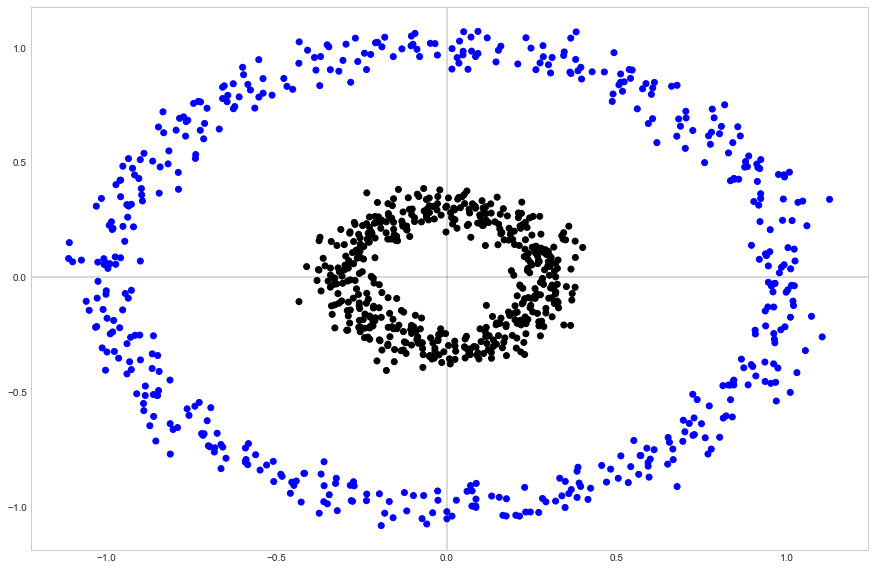

In [5]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,10))
plt.axhline(c = 'black', alpha = 0.2)
plt.axvline(c = 'black', alpha = 0.2)
plt.scatter(X[:,0], X[:,1], c = colors)
plt.grid(False)
plt.show()

Running our model

In [6]:
X = X.T 
k = kernel(gamma = 10).rbf
kpca = KPCA(X, k, 2)
scores = kpca.project()

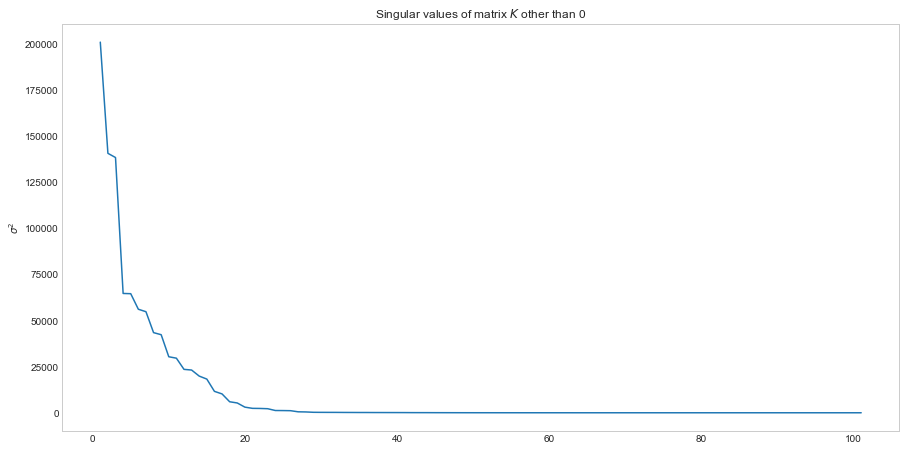

In [7]:
kpca.plot_singular_values(grid = False)

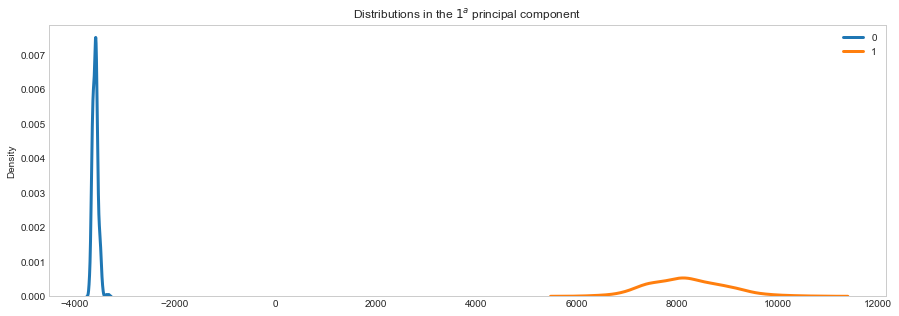

In [8]:
kpca.plot_density(labels = Y, dim=1, grid = False)

(2, 1000)


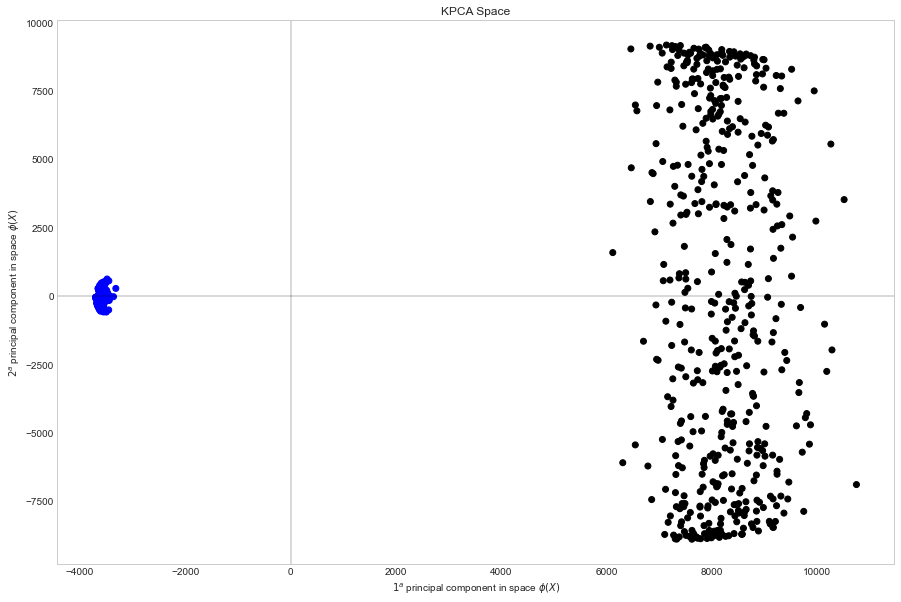

In [9]:
kpca.plot_scores_2d(colors = colors, grid = False, dim_1 = 1, dim_2 = 2)